In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertForMaskedLM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
!kaggle datasets download -d georgemedhat/cleaneddatasetfornlp
!unzip "/content/cleaneddatasetfornlp.zip"

Dataset URL: https://www.kaggle.com/datasets/georgemedhat/cleaneddatasetfornlp
License(s): apache-2.0
100% 390M/390M [00:04<00:00, 90.5MB/s]
100% 390M/390M [00:04<00:00, 98.4MB/s]
Archive:  /content/cleaneddatasetfornlp.zip
  inflating: Cleaned/CleanedTest.csv  
  inflating: Cleaned/CleanedTrain.csv  


In [ ]:
!kaggle datasets download -d zescoo/bert-10000
!unzip "/content/bert-10000.zip"

Dataset URL: https://www.kaggle.com/datasets/zescoo/bert-10000
License(s): unknown
 98% 381M/387M [00:05<00:00, 69.2MB/s]
100% 387M/387M [00:05<00:00, 70.4MB/s]
Archive:  /content/bert-10000.zip
  inflating: BERT_10000.pth          


In [ ]:
data =pd.read_csv("/content/Cleaned/CleanedTrain.csv")

In [ ]:
data.head()

,Polarity,Review,sentiment
0,2,sound track beautiful paints senery mind well ...,positive
1,2,im reading lot reviews saying best game soundt...,positive
2,2,soundtrack favorite music time hands down inte...,positive
3,2,truly like soundtrack enjoy video game music p...,positive
4,2,played game know divine music is every single ...,positive


In [ ]:
data = data[['Polarity', 'Review']].reset_index(drop=True)
data.head()

,Polarity,Review
0,2,sound track beautiful paints senery mind well ...
1,2,im reading lot reviews saying best game soundt...
2,2,soundtrack favorite music time hands down inte...
3,2,truly like soundtrack enjoy video game music p...
4,2,played game know divine music is every single ...


In [ ]:
def map_values(value):
  if value == 1:
    return "negative"
  elif value == 2:
    return "positive"

In [ ]:
data['sentiment'] = data["Polarity"].apply(map_values)

In [ ]:
data.head(10)

,Polarity,Review,sentiment
0,2,sound track beautiful paints senery mind well ...,positive
1,2,im reading lot reviews saying best game soundt...,positive
2,2,soundtrack favorite music time hands down inte...,positive
3,2,truly like soundtrack enjoy video game music p...,positive
4,2,played game know divine music is every single ...,positive
5,2,quite sure actually taking time read played ga...,positive
6,1,selfpublished book want know whyread paragraph...,negative
7,2,loved whisper wicked saints story amazing plea...,positive
8,2,finished reading whisper wicked saints fell lo...,positive
9,2,easy read book made want keep reading on easy ...,positive


In [ ]:
def load_data(data):
  texts = data['Review'].tolist()
  labels = [1 if sentiment == "positive" else 0 for sentiment in data['sentiment'].tolist()]
  return texts ,labels

In [ ]:
subset_size = 1000
subset = data.sample(n=subset_size ,random_state=42)
subset

,Polarity,Review,sentiment
1711148,2,book must anyone wants contribute remaining qu...,positive
3417606,2,one best thought provoking books read last ten...,positive
4453,1,want specific color random one thanks reviews ...,negative
3538239,1,book composed exquisitely yet unmistakenly ful...,negative
3288877,1,boy show go downhill first season great high h...,negative
...,...,...,...
2359717,1,put book sloughing longwinded introduction mak...,negative
3034046,2,good book basic information need know topic ho...,positive
2400269,1,im sure book could helpful applicable situatio...,negative
1871607,2,halloween bash great fun younger children espe...,positive


In [ ]:
value_counts = subset.Polarity.value_counts()
value_counts

,count
Polarity,
1,504
2,496


<Axes: xlabel='Polarity'>

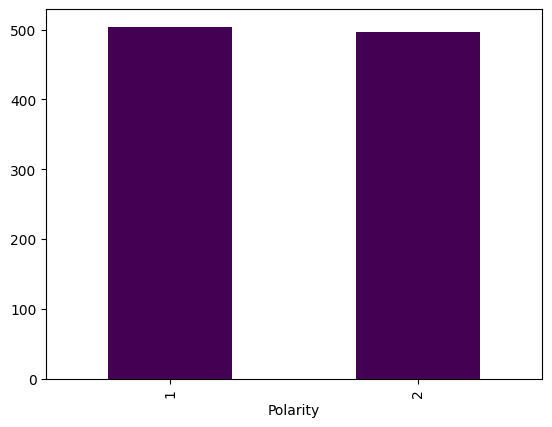

In [ ]:
value_counts.plot(kind="bar",x=value_counts.keys,colormap='viridis')

In [ ]:
texts ,labels = load_data(subset)

In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self , texts , labels , tokenizer , max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)
  def __getitem__(self ,idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding= self.tokenizer(text , return_tensors='pt' , max_length=self.max_length , padding ="max_length" , truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self , bert_model_name , num_classes):
    super(BERTClassifier ,self).__init__()
    self.bert =BertModel.from_pretrained(bert_model_name)

    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size ,num_classes)

  def forward(self, input_ids ,attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask = attention_mask)
    pooled_output = outputs.pooler_output
    x= self.dropout(pooled_output)
    logits =  self.fc(x)
    return logits

In [ ]:
def train(model , data_loader , optimizer , scheduler , device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask =batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids,attention_mask=attention_mask)
    loss = nn.CrossEntropyLoss()(outputs , labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
# def evaluate(model , data_loader , device):
#   model.eval()
#   predictions= []
#   actual_labels = []
#   with torch.no_grad():
#     for batch in data_loader:
#       input_ids = batch['input_ids'].to(device)
#       attention_mask = batch['attention_mask'].to(device)

#       labels =batch['label'].to(device)
#       outputs = model(input_ids= input_ids ,attention_mask=attention_mask)
#       _,preds = torch.max(outputs, dim=1)
#       predictions.extend(preds.cpu().tolist())
#     return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)


In [ ]:
def predict_sentiment(text , model , tokenizer, device , max_length=128):
  model.eval()
  encoding = tokenizer(text , return_tensors='pt' , max_length=max_length , padding='max_length' , truncation=True)
  input_ids = encoding['input_ids'].to(device)
  attention_mask= encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids= input_ids , attention_mask = attention_mask)
    _,preds = torch.max(outputs , dim=1)
    return "positive" if preds.item() == 1 else "negative"


In [ ]:
bert_model_name = "bert-base-uncased"
num_classes = 2
max_length= 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
print("train_texts : ",np.shape(train_texts))
print("val_texts : ",np.shape(val_texts))
print("train_labels : ",np.shape(train_labels))
print("val_labels : ",np.shape(val_labels))

train_texts :  (800,)
val_texts :  (200,)
train_labels :  (800,)
val_labels :  (200,)


In [ ]:

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts , train_labels , tokenizer , max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [ ]:
model.load_state_dict(torch.load("/content/BERT_10000.pth"))

<ipython-input-59-dd570a6b162f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/BERT_10000.pth"))


<All keys matched successfully>

In [ ]:
optimizer = AdamW(model.parameters() , lr= learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        97
           1       0.99      0.93      0.96       103

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

Epoch 2/4
Validation Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.92      0.99      0.96        97
           1       0.99      0.92      0.95       103

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200

Epoch 3/4
Validation Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.92      0.99      0.96        97
           1       0.99      0.92      0.95       103

    accuracy                           0.95       200
   macro avg  

In [ ]:
# Get predictions and actual labels
predictions = []
actual_labels = []
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(actual_labels, predictions)

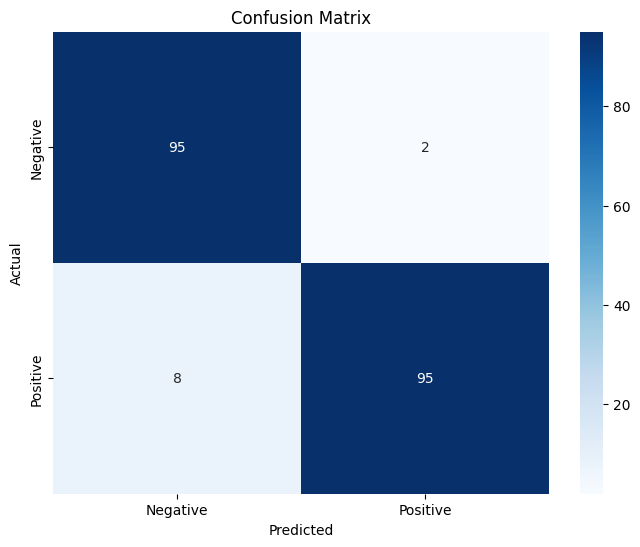

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model.state_dict(), "NEW_BERT.pth")

In [ ]:
# model.tokenizer

In [ ]:
test_text2 = "I purchased this product with high hopes, but it turned out to be a total waste of money"
sentiment2 = predict_sentiment(test_text2, model, tokenizer, device)
print(f"Predicted sentiment: {sentiment2}")

Predicted sentiment: negative


In [ ]:
from google.colab import files

files.download("NEW_BERT.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
file_location = os.path.abspath("NEW_BERT.pth")
print(f"The file is saved at: {file_location}")


The file is saved at: /content/NEW_BERT.pth
